In [1]:
# TensorFlow imports
import tensorflow as tf
from tensorflow.keras import layers, regularizers
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

# Check TensorFlow version
print("TensorFlow version:", tf.__version__)
assert "2." in tf.__version__, "This notebook is designed to run on TensorFlow 2.x"


TensorFlow version: 2.14.0


In [2]:
# Additional imports here
import os
import matplotlib.pyplot as plt
import time
import numpy as np
import pandas as pd
import seaborn as sns

from scipy.stats import mode
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

from tqdm import tqdm   # For progress bar

In [3]:
# Mount drive for data access
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Initialize directories
gan_data_dir = '/content/drive/My Drive/ML-GroupProject/Processed_Data/GAN_Training'

classifier_train_dir = '/content/drive/My Drive/ML-GroupProject/Processed_Data/Classifier_Training'

classifier_test_dir = '/content/drive/My Drive/ML-GroupProject/Processed_Data/Classifier_Testing'

In [5]:
# NOTE: In hindsight, should have made subfolders to denote classes for training...
#       Instead, will have to parse this information

# Function to parse label from filename
def parse_label(filename):
    if filename.startswith('N_'):
        return 0  # normal
    elif filename.startswith('G_'):
        return 1  # glioma_tumor
    elif filename.startswith('M_'):
        return 2  # meningioma_tumor
    elif filename.startswith('P_'):
        return 3  # pituitary_tumor
    else:
        return -1  # Unknown class

In [6]:
# Load dataset for Classifier Training

batch_size = 32  # Adjust as needed

# Function to load and preprocess images. Made a bit more 'involved' due to not having subfolders setup for class designations
def load_and_preprocess_image(file_path):
    image = load_img(file_path, color_mode='grayscale', target_size=(256, 256)) # Convert to greyscale
    image = img_to_array(image)         # Convert PIL image into numpy array
    image = (image - 127.5) / 127.5     # Normalize the images to [-1, 1]
    return image

# Load and preprocess images from a directory
def create_dataset_from_directory(directory):
    images = []
    labels = []
    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)
        label = parse_label(filename)
        if label != -1:  # Only add if the label is known
            image = load_and_preprocess_image(file_path)
            images.append(image)
            labels.append(label)
    return np.array(images), np.array(labels)

# Create training and testing datasets
train_images, train_labels = create_dataset_from_directory(classifier_train_dir)
test_images, test_labels = create_dataset_from_directory(classifier_test_dir)

In [7]:
# Define Discriminator architecture

def make_discriminator_model():
    model = tf.keras.Sequential()

    # Input layer: 256x256x1
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=(256, 256, 1)))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))  # Used to prevent overfitting. Random set of neurons on each pass wont be used

    # Downsampling to 128x128
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Downsampling to 64x64
    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())  # Provides more stable outputs, perfect for feature extracting!!!
    model.add(layers.LeakyReLU())
    #model.add(layers.Dropout(0.3))

    # Downsampling to 32x32
    model.add(layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Flatten and final dense layer for classification
    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

# Instantiate the Discriminator
discriminator = make_discriminator_model()

In [8]:
# Setup save checkpoints

checkpoint_dir = '/content/drive/My Drive/ML-GroupProject/Training_Checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(discriminator=discriminator)

In [9]:
# Specify exact checkpoint we wish to load
checkpoint_path = os.path.join(checkpoint_dir, "ckpt-100")
if os.path.exists(checkpoint_path + '.index'):
    checkpoint.restore(checkpoint_path)
    print(f"Restored from checkpoint: {checkpoint_path}")
else:
    print(f"Checkpoint not found: {checkpoint_path}, Failure to load.")

Restored from checkpoint: /content/drive/My Drive/ML-GroupProject/Training_Checkpoints/ckpt-100


In [10]:
# Modify the discriminator model for feature extraction

# We want to grab the features after the layer with batch normilization

batch_norm_layer_index = [i for i, layer in enumerate(discriminator.layers) if isinstance(layer, layers.BatchNormalization)][0] + 1

feature_extractor = tf.keras.Model(
    inputs=discriminator.inputs,
    outputs=discriminator.layers[batch_norm_layer_index].output
)

# Extract features for training data
train_features = feature_extractor.predict(train_images)

# Extract features for testing data
test_features = feature_extractor.predict(test_images)

print('train feature shape', train_features.shape)
print('test feature shape', test_features.shape)

5/5 [==============================] - 0s 117ms/step
train feature shape (594, 32, 32, 256)
test feature shape (149, 32, 32, 256)


In [11]:
# Test Random Forest Classifer for classification

# NOTE: features being passed to classifier have 4 dims. Need to reshape output into 2D format

# Flatten the features for training
train_features_flat = train_features.reshape(train_features.shape[0], -1)

# Flatten the features for testing
test_features_flat = test_features.reshape(test_features.shape[0], -1)

# Initialize the classifier
rf_classifier = RandomForestClassifier(n_estimators=200)

# Train the classifier
rf_classifier.fit(train_features_flat, train_labels)

# Predict on the test set
rf_predictions = rf_classifier.predict(test_features_flat)

# Evaluate the RF classifier
print("\nClassification Report:\n", classification_report(test_labels, rf_predictions, target_names=['normal', 'glioma_tumor', 'meningioma_tumor', 'pituitary_tumor']))

# Generate confusion matrix
conf_matrix_rf = confusion_matrix(test_labels, rf_predictions)


Classification Report:
                   precision    recall  f1-score   support

          normal       0.85      0.52      0.65        21
    glioma_tumor       0.71      0.81      0.76        43
meningioma_tumor       0.56      0.55      0.55        44
 pituitary_tumor       0.82      0.88      0.85        41

        accuracy                           0.71       149
       macro avg       0.73      0.69      0.70       149
    weighted avg       0.72      0.71      0.71       149



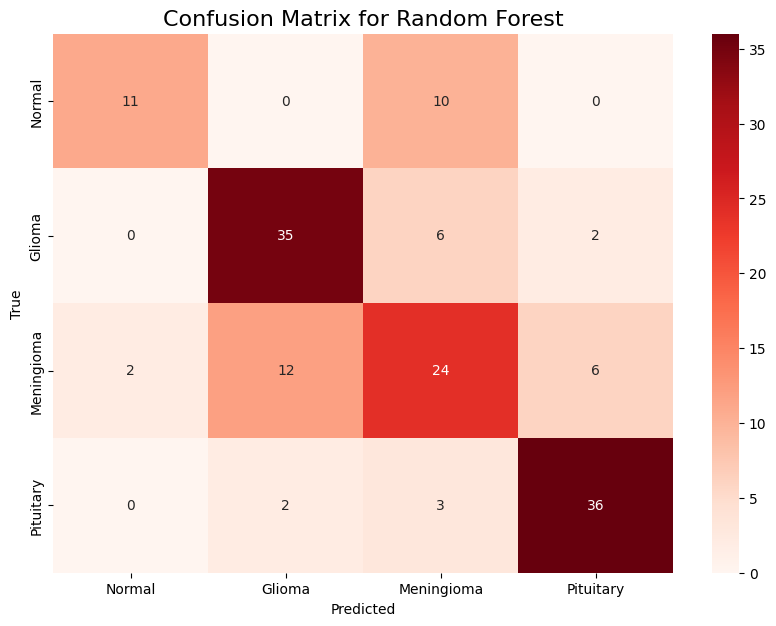

In [12]:
# Plot RF confusion matrix

plt.figure(figsize=(10, 7))
ax = sns.heatmap(conf_matrix_rf, annot=True, fmt='g', cmap='Reds', xticklabels=['Normal', 'Glioma', 'Meningioma', 'Pituitary'], yticklabels=['Normal', 'Glioma', 'Meningioma', 'Pituitary'])
plt.xlabel('Predicted')
plt.ylabel('True')
ax.set_title('Confusion Matrix for Random Forest', fontsize=16)
plt.show()

In [13]:
# Test simple neural net for classification

# Define the model
nn_classifier = Sequential([
    Flatten(input_shape=train_features.shape[1:]),  # Flattening within the model
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(4, activation='softmax')  # Assuming 4 classes in your classification problem
])

# Compile the model
nn_classifier.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
nn_classifier.fit(train_features, train_labels, epochs=10, validation_split=0.2)

# Predict on the test set
nn_predictions = nn_classifier.predict(test_features)
nn_predictions = np.argmax(nn_predictions, axis=1)  # Convert probabilities to class labels

# Evaluate the NN classifier
print("\nClassification Report:\n", classification_report(test_labels, nn_predictions, target_names=['normal', 'glioma_tumor', 'meningioma_tumor', 'pituitary_tumor']))

# Generate confusion matrix
conf_matrix_nn = confusion_matrix(test_labels, nn_predictions)

Epoch 1/10
15/15 [==============================] - 4s 86ms/step - loss: 7.9667 - accuracy: 0.4126 - val_loss: 3.0533 - val_accuracy: 0.5126
Epoch 2/10
15/15 [==============================] - 1s 49ms/step - loss: 1.1886 - accuracy: 0.8021 - val_loss: 1.9119 - val_accuracy: 0.6387
Epoch 3/10
15/15 [==============================] - 1s 56ms/step - loss: 0.3027 - accuracy: 0.9474 - val_loss: 1.8779 - val_accuracy: 0.7563
Epoch 4/10
15/15 [==============================] - 1s 49ms/step - loss: 0.0573 - accuracy: 0.9832 - val_loss: 1.6978 - val_accuracy: 0.7563
Epoch 5/10
15/15 [==============================] - 1s 49ms/step - loss: 0.0184 - accuracy: 0.9916 - val_loss: 1.9679 - val_accuracy: 0.6639
Epoch 6/10
15/15 [==============================] - 1s 38ms/step - loss: 0.0230 - accuracy: 0.9916 - val_loss: 1.6421 - val_accuracy: 0.8067
Epoch 7/10
15/15 [==============================] - 0s 34ms/step - loss: 0.0096 - accuracy: 0.9958 - val_loss: 1.6528 - val_accuracy: 0.7479
Epoch 8/10
15

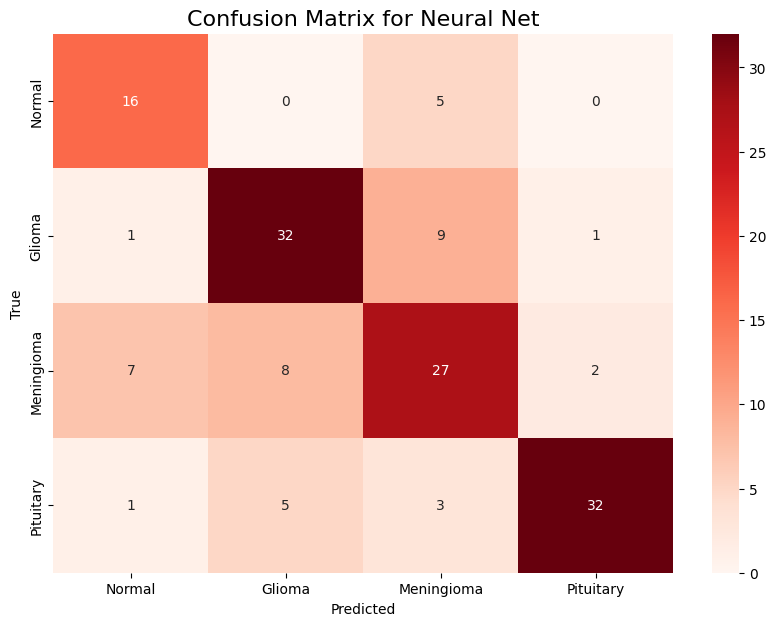

In [14]:
# Plot NN confusion matrix

plt.figure(figsize=(10, 7))
ax = sns.heatmap(conf_matrix_nn, annot=True, fmt='g', cmap='Reds', xticklabels=['Normal', 'Glioma', 'Meningioma', 'Pituitary'], yticklabels=['Normal', 'Glioma', 'Meningioma', 'Pituitary'])
plt.xlabel('Predicted')
plt.ylabel('True')
ax.set_title('Confusion Matrix for Neural Net', fontsize=16)
plt.show()

In [15]:
# NOTE: Accuracies from classifiers above are OK, but not great.
#       Lets try to ensemble them and see if accuracy improves.

# Combine predictions
combined_predictions = np.array([rf_predictions, nn_predictions])

# Perform majority voting
final_predictions, _ = mode(combined_predictions, axis=0)

# Evaluate the ensemble
print("\nClassification Report:\n", classification_report(test_labels, final_predictions.reshape(-1), target_names=['normal', 'glioma_tumor', 'meningioma_tumor', 'pituitary_tumor']))


Classification Report:
                   precision    recall  f1-score   support

          normal       0.68      0.90      0.78        21
    glioma_tumor       0.64      0.84      0.73        43
meningioma_tumor       0.65      0.45      0.53        44
 pituitary_tumor       0.91      0.76      0.83        41

        accuracy                           0.71       149
       macro avg       0.72      0.74      0.72       149
    weighted avg       0.72      0.71      0.70       149



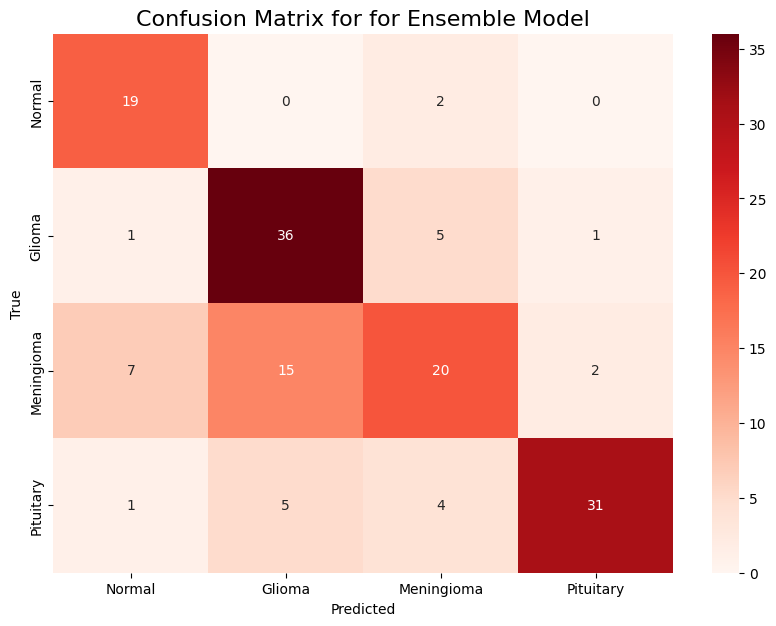

In [16]:
# Plot the ensemble method confusion matrix

conf_matrix_ensemble = confusion_matrix(test_labels, final_predictions.reshape(-1))

# Set up the matplotlib figure
plt.figure(figsize=(10, 7))

# Add labels
ax = sns.heatmap(conf_matrix_ensemble, annot=True, fmt='g', cmap='Reds', xticklabels=['Normal', 'Glioma', 'Meningioma', 'Pituitary'], yticklabels=['Normal', 'Glioma', 'Meningioma', 'Pituitary'])
plt.xlabel('Predicted')
plt.ylabel('True')
ax.set_title('Confusion Matrix for for Ensemble Model', fontsize=16)

# Show the plot
plt.show()

# Training is complete!
Now it is time to test on the kaggle set

In [17]:
# Load directory
test_set_dir = '/content/drive/My Drive/ML-GroupProject/kaggle_solutionSet'

# Function to load and preprocess images from the Kaggle test set directory
def load_kaggle_test_set(directory):
    images = []
    filenames = []
    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)
        image = load_and_preprocess_image(file_path)
        images.append(image)
        filenames.append(filename)     # Store filename for submission file
    return np.array(images), filenames

kaggle_test_images, kaggle_test_filenames = load_kaggle_test_set(test_set_dir)

In [18]:
# Extract features
test_features = feature_extractor.predict(kaggle_test_images)

# Flatten the features to a 2D array for compatibility with RandomForest
test_features_flattened = test_features.reshape(test_features.shape[0], -1)

# Ensemble predictions
rf_predictions = rf_classifier.predict(test_features_flattened)
nn_predictions = nn_classifier.predict(test_features)                     # Neural Net can use 4D features as is, no need to flatten
nn_predictions = np.argmax(nn_classifier.predict(test_features), axis=1)  # Neural Net outputs probabilities. Need to collapse into predictions

# Combine and vote
combined_predictions = np.array([rf_predictions, nn_predictions])
final_predictions, _ = mode(combined_predictions, axis=0)

20/20 [==============================] - 0s 22ms/step


In [19]:
# Map numeric predictions to class names
class_names = ['normal', 'glioma_tumor', 'meningioma_tumor', 'pituitary_tumor']
mapped_predictions = [class_names[pred] for pred in final_predictions.reshape(-1)]

# Create DataFrame for Kaggle submission
submission_df = pd.DataFrame({
    'ID': kaggle_test_filenames,
    'Class': mapped_predictions
})

# Save to CSV
submission_csv_path = '/content/drive/My Drive/ML-GroupProject/Kaggle_Submission_Joe.csv'
submission_df.to_csv(submission_csv_path, index=False)